# 5章 線形回帰

## 5.1 問題の定義
- ボストン・データセット

## 5.2 本章で学ぶ重要概念
- 線形関数(nn.Linear)
- カスタムクラス定義
- 平均二乗誤差(nn.MSELoss)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)

## 5.3 線形関数(nn.Linear)

In [2]:
# 入力:2 出力:3 の線形関数の定義
l3 = nn.Linear(2, 3)

### 1入力1出力

In [3]:
# 乱数の固定
torch.manual_seed(123)

# 入力:1, 出力:1の線形関数の定義
l1 = nn.Linear(1, 1)

# 線形関数の表示
print(l1)

Linear(in_features=1, out_features=1, bias=True)


In [4]:
# パラメータ名、パラメータ値、shapeの表示
for param in l1.named_parameters():
    print('name: ', param[0])
    print('tensor: ', param[1])
    print('shape: ', param[1].shape)
    print('')

name:  weight
tensor:  Parameter containing:
tensor([[-0.4078]], requires_grad=True)
shape:  torch.Size([1, 1])

name:  bias
tensor:  Parameter containing:
tensor([0.0331], requires_grad=True)
shape:  torch.Size([1])



- パラメータは2つ。weightとbias。
- requires_gradはTrue。（テンソル変数を宣言した場合はFalseだけど、nn.LinearなのでTrue。学習対象になるのがデフォなので。）
- weightとbiasはデフォでランダムな値に設定されている。

In [5]:
# 乱数ではなく明示的に設定したい場合
# 初期値設定
nn.init.constant_(l1.weight, 2.0)
nn.init.constant_(l1.bias, 1.0)

# 結果確認
print(l1.weight)
print(l1.bias)

Parameter containing:
tensor([[2.]], requires_grad=True)
Parameter containing:
tensor([1.], requires_grad=True)


In [6]:
# ダミーデータをこの関数にかけて1次関数として動作することを確認
# テスト用データ生成

# x_npをNumpy配列で定義
x_np = np.arange(-2, 2.1, 1)

# テンソル変数化
x = torch.tensor(x_np).float() # テンソル化の際にfloatしないとエラーになる

# サイズを(N, 1)に変更
x = x.view(-1, 1)

# 結果
print(x.shape)
print(x)


torch.Size([5, 1])
tensor([[-2.],
        [-1.],
        [ 0.],
        [ 1.],
        [ 2.]])


In [7]:
# 1次関数のテスト
# l1は2x+1
y = l1(x)

print(y.shape)
print(y.data)

torch.Size([5, 1])
tensor([[-3.],
        [-1.],
        [ 1.],
        [ 3.],
        [ 5.]])


### 2入力1出力
- 5章で取り上げる重回帰と同じパターン
- y = x1 + x2 + 2

In [8]:
# 入力:2 出力:1の線形関数の定義
l2 = nn.Linear(2,1)

# 初期値設定
nn.init.constant_(l2.weight, 1.0)
nn.init.constant_(l2.bias, 2.0)

# 結果確認
print(l2.weight)
print(l2.bias)

Parameter containing:
tensor([[1., 1.]], requires_grad=True)
Parameter containing:
tensor([2.], requires_grad=True)


In [9]:
# 入力テンソルは列が二つの2次元テンソル
# ココでは4行2列のテストデータを準備する

# 2次元Numpy配列
x2_np = np.array([[0,0], [0,1], [1,0], [1,1]])

# テンソル変数化
x2 = torch.tensor(x2_np).float()

# 結果確認
print(x2.shape)
print(x2)

torch.Size([4, 2])
tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])


In [10]:
# このデータx2を使って、関数を呼び出す
# 関数値計算
y2 = l2(x2)

# shapeと値を確認
print(y2.shape)
print(y2.data)

torch.Size([4, 1])
tensor([[2.],
        [3.],
        [3.],
        [4.]])


### 2入力3出力

In [11]:
# 入力:2 出力:3の線形関数の定義
l3 = nn.Linear(2, 3)

# 初期値設定
nn.init.constant_(l3.weight[0,:], 1.0) # 重み行列の初期値を行ごとに別の値を設定
nn.init.constant_(l3.weight[1,:], 2.0)
nn.init.constant_(l3.weight[2,:], 3.0)
nn.init.constant_(l3.bias, 2.0)

# 結果確認
print(l3.weight)
print(l3.bias)

Parameter containing:
tensor([[1., 1.],
        [2., 2.],
        [3., 3.]], requires_grad=True)
Parameter containing:
tensor([2., 2., 2.], requires_grad=True)


In [12]:
# 関数値計算
y3 = l3(x2)

# 結果確認
print(y3.shape) # 入力(4,2)x関数(2,3)=出力(4,3)
print(y3.data)

torch.Size([4, 3])
tensor([[2., 2., 2.],
        [3., 4., 5.],
        [3., 4., 5.],
        [4., 6., 8.]])


### 5.4 カスタムクラスを利用したモデル定義
1. 予測関数（カスタムクラスによるモデル定義）
2. 損失関数
3. 最適化関数

In [13]:
# モデルの定義のやり方

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        # 親クラスnn.Moduleの初期値呼び出し
        super().__init__()

        # 出力層の定義
        self.l1 = nn.Linear(n_input, n_output)
    
    # 予測関数の定義
    def forward(self, x):
        x1 = self.l1(x) # 線形回帰
        return x1

- ポイント
    - （1.5節で説明した）カスタムクラス定義によりNetというクラスを作る
    - Netの親クラスはnn.Module
    - クラス内部に**forward関数**が定義されて、この関数で予測処理を実装する

In [14]:
# 予測

# ダミー入力
inputs = torch.ones(100, 1)

# インスタンスの生成(1入力1出力の設計モデル)
n_input = 1
n_output = 1
net = Net(n_input, n_output)

# 予測
outputs = net(inputs)

- 上のコードは、本書でこれから非常によく出てくるパターンの一つ。
- 予測をするときは、必ずこのコードが出てくる

## 5.5 MSELossクラスを利用した損失関数
- 損失loss = 予測関数と損失関数を組み合わせた合成関数
- 損失計算 = この合成関数で計算すること
- この合成関数（損失）はパラメータ（weightとbias）を引数とする
- 勾配計算 = 合成関数（損失）をパラメータで偏微分すること
- 勾配計算の結果が勾配降下法のパラメータ修正に用いられる

In [16]:
# このコードはエラーになる。labels1が未定義だから。

# # 損失関数: 平均二乗誤差
# criterion = nn.MSELoss() # 3章でスクラッチで定義したmse関数と同じ

# # 誤差計算
# # 「ディープラーニングの数学」に合わせて2で割った値と損失とした
# # 予測関数と損失関数の合成関数 = 損失
# loss = criterion(outputs, labels1) / 2.0 # p.180-181を参照らしい

# # 勾配計算
# loss.backward()

p.170の表5-1 各実習で利用する損失関数

| 章 | モデルの種別 | 損失関数 | 処理概要 |
| --- | --- | --- | --- |
| 5 | 回帰 | MSELoss | 平均二乗誤差 |
| 6 | 二値分類 | BCELoss | 二値分類用交差エントロピー関数 |
| 7～11 | 多値分類 | CrossEntropyLoss | 多値分類用交差エントロピー関数 |
| 12 | 2値分類 | CrossEntropyLoss | 多値分類用交差エントロピー関数 |

## 5.6 データ準備
UCI公開データセットのうち、回帰でよく使われる「ボストン・データセット」を用いる。  

https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

オリジナルのデーセットは、17項目の入力値から、不動産価格を予測する目的のものだが、
一番単純な「単回帰モデル」(1入力)のモデルを作るため、このうち``RM``の1項目だけを抽出する。


In [17]:
# 学習用データ準備

# 「ボストン・データセット」はscikit-learnのライブラリでも取得できるが、
# その場合、将来版で利用できなくなる予定のため、別Webサイトから取得する
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", 
    skiprows=22, header=None)
x_org = np.hstack([raw_df.values[::2, :], 
    raw_df.values[1::2, :2]])
yt = raw_df.values[1::2, 2]
feature_names = np.array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO','B', 'LSTAT'])

# 結果確認
print('元データ', x_org.shape, yt.shape)
print('項目名: ', feature_names)

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\fx28202.DC00\AppData\Local\Temp\ipykernel_23860\196743843.py:6: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+",


元データ (506, 13) (506,)
項目名:  ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [18]:
# データ絞り込み（項目RMのみ）
x = x_org[:, feature_names == 'RM']
print('絞り込み後', x.shape)
print(x[:5, :1])

# 正解データyの表示
print('正解データ')
print(yt[:5])

絞り込み後 (506, 1)
[[6.575]
 [6.421]
 [7.185]
 [6.998]
 [7.147]]
正解データ
[24.  21.6 34.7 33.4 36.2]


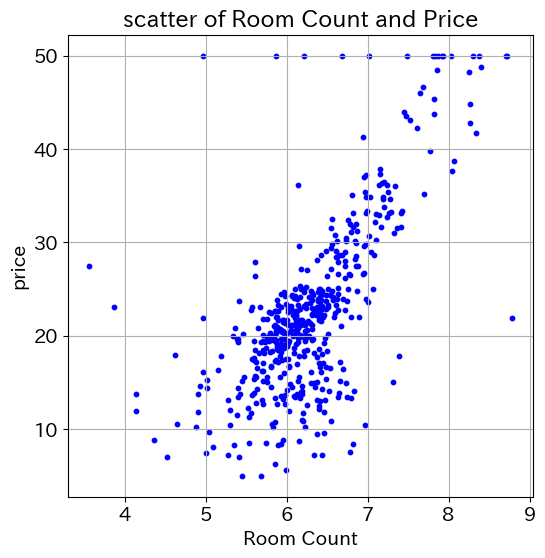

In [19]:
# 散布図の表示
plt.scatter(x, yt, s=10, c='b')
plt.xlabel('Room Count')
plt.ylabel('price')
plt.title('scatter of Room Count and Price')
plt.show()

## 5.7 モデル定義
### 変数定義

In [20]:
# 変数定義

# 入力次元数
n_input = x.shape[1]

# 出力次元数
n_output = 1

print(f'入力次元数: {n_input} 出力次元数: {n_output}')

入力次元数: 1 出力次元数: 1


機械学習やディープラーニングモデルとは、結局 **「入力ベクトルに対して出力ベクトルを返す関数である」**

### 機械学習モデル(予測モデル)のクラス定義

In [21]:
# 機械学習モデル（予測モデル）のクラス定義
class Net(nn.Module):
    def __init__(self, n_input, n_output):
        # 親クラスnn.Moduleの初期値呼び出し
        super().__init__()

        # 出力層の定義
        self.l1 = nn.Linear(n_input, n_output)

        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的
        nn.init.constant_(self.l1.weight, 1.0)
        nn.init.constant_(self.l1.bias, 1.0)

    def forward(self, x):
        x1 = self.l1(x) # 線形回帰
        return x1

- ポイント
    - カスタムクラスNetが、nn.Moduleを継承している
    - 冒頭の__init__関数で初期化処理をしている
    - インスタンス生成時にはn_inputとn_outputの２つを引数として取る
    - __init__関数の内部で親クラス__init__関数を呼び出している
    - わからくなったら1.5節を見返すこと

### インスタンス生成

In [22]:
# インスタンスの生成
# 1入力1出力の線形モデル
net = Net(n_input, n_output)

### モデル内の変数値表示

In [23]:
# モデル内のパラメータの確認
# モデル内の変数取得にはnamed_parameters()を使う
# 結果の第一要素が名前、第二要素が値
#
# predict.weightとpredict.biasがあることが確認できる
# 初期値はどちらも1.0になっている

for parameter in net.named_parameters():
    print(f"変数名: {parameter[0]}")
    print(f"変数値: {parameter[1].data}")

変数名: l1.weight
変数値: tensor([[1.]])
変数名: l1.bias
変数値: tensor([1.])


### parameters関数の呼び出し

In [24]:
# パラメータのリスト取得にはparameters関数を使う
for parameter in net.parameters():
    print(parameter)

Parameter containing:
tensor([[1.]], requires_grad=True)
Parameter containing:
tensor([1.], requires_grad=True)


### モデルの概要表示

In [25]:
# モデルの概要表示
print(net)

Net(
  (l1): Linear(in_features=1, out_features=1, bias=True)
)


In [26]:
# モデルのサマリー表示
from torchinfo import summary
summary(net, (1,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1]                       --
├─Linear: 1-1                            [1]                       2
Total params: 2
Trainable params: 2
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### 損失関数と最適化関数の定義
- 予測関数
- 損失関数 ←これ
- 最適化関数　←これ

In [27]:
# 損失関数: 平均二乗誤差
criterion = nn.MSELoss() # MSELossについては5.5節で説明

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)  # SGDについては3.12節で説明

## 5.8 勾配降下法

### 入力値xと正解値ytのテンソル化

In [28]:
# 入力変数xと正解値ytのテンソル変数化
inputs = torch.tensor(x).float()
labels = torch.tensor(yt).float()

# 次元数確認
print(inputs.shape)
print(labels.shape)

torch.Size([506, 1])
torch.Size([506])


#### ポイント
- labelsを使って、損失を計算する。MSELossのインスタンスであるcriterion関数に渡す。（予測値も一緒に渡す）
- その時に、引数はN次元のベクトル形式ではなく、(N,1)次元の行列形式であることが必要
- view関数を利用してデータサイズを変更する

In [29]:
# 損失計算用にlabels変数を(N, 1)次元の行列に変換する
labels1 = labels.view(-1, 1)

# 次元数確認
print(labels1.shape) # (N,1)次元になっていることを確認

torch.Size([506, 1])


- 準備完了。あとは以下の手順を繰り返せば、勾配降下法が実現できる
    1. 予測値の計算
    2. 損失の計算
    3. 勾配の計算
    4. パラメータの更新

### 1. 予測計算

In [30]:
# 予測値の計算
outputs = net(inputs)

### 2. 損失計算

In [31]:
# 損失の計算
loss = criterion(outputs, labels1)

# 損失の取得
print(f"{loss.item():.5f}")

308.44986


### 計算グラフの可視化
- 3章では、paramsの引数は、手でリストを作ったが、今回は入力パラメータがnetオブジェクトに含まれているので、dict(net.named_parameters())と指定できる。

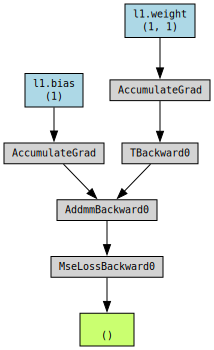

In [32]:
# 損失のグラフ化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 3. 勾配計算

In [33]:
# 予測値の計算
outputs = net(inputs)

# 損失の計算
loss = criterion(outputs, labels1) # labels1を使う

# 勾配計算
loss.backward()

# 勾配の結果が取得可能になる
print(net.l1.weight.grad)
print(net.l1.bias.grad)

tensor([[-199.6421]])
tensor([-30.4963])


### 4. パラメータ更新

In [34]:
# パラメータ修正
optimizer.step()

# パラメータとバイアス値が変わる。学習率も参照している。
print(net.l1.weight) # 
print(net.l1.bias)

Parameter containing:
tensor([[2.9964]], requires_grad=True)
Parameter containing:
tensor([1.3050], requires_grad=True)


- 繰り返し処理をするときの注意点
    - 勾配値の初期化
        - 勾配計算(backward関数)が呼び出されるたびに、値が加算されてしまうため

In [40]:
# 勾配地の初期化
optimizer.zero_grad()

# 勾配値がすべてゼロになっていることを確認する
# 少しテキストと違う。テキストはtensor([[0.]])だが、手元はNoneになった。
print(net.l1.weight.grad) 
print(net.l1.bias.grad)

None
None


### 繰り返し計算
- 以上で繰り返し処理の中でやるべき４つの計算をすべて確認した。
- 後は、これを繰り返すだけ。

In [41]:
# 学習率
lr = 0.01

# インスタンス生成
net = Net(n_input, n_output)

# 損失関数: 平均二乗誤差
criterion = nn.MSELoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50000

# 評価結果記録用（損失のみ記録）
history = np.zeros((0, 2))

In [42]:
# 繰り返し計算メインループ
for epoch in range(num_epochs):
    # 勾配初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    # 「ディープラーニングの数学」に合わせて2で割った値と損失とした
    loss = criterion(outputs, labels1) / 2.0

    # 勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    # 100回に1回結果表示
    if epoch % 100 == 0:
        history = np.vstack((history, np.array([epoch, loss.item()]))) # 損失の履歴保存
        print(f'Epoch: {epoch} loss: {loss.item():.5f}')   
    

Epoch: 0 loss: 154.22493
Epoch: 100 loss: 29.61752
Epoch: 200 loss: 29.43177
Epoch: 300 loss: 29.25043
Epoch: 400 loss: 29.07340
Epoch: 500 loss: 28.90057
Epoch: 600 loss: 28.73186
Epoch: 700 loss: 28.56716
Epoch: 800 loss: 28.40636
Epoch: 900 loss: 28.24939
Epoch: 1000 loss: 28.09615
Epoch: 1100 loss: 27.94654
Epoch: 1200 loss: 27.80050
Epoch: 1300 loss: 27.65792
Epoch: 1400 loss: 27.51873
Epoch: 1500 loss: 27.38285
Epoch: 1600 loss: 27.25020
Epoch: 1700 loss: 27.12070
Epoch: 1800 loss: 26.99428
Epoch: 1900 loss: 26.87086
Epoch: 2000 loss: 26.75037
Epoch: 2100 loss: 26.63275
Epoch: 2200 loss: 26.51792
Epoch: 2300 loss: 26.40582
Epoch: 2400 loss: 26.29639
Epoch: 2500 loss: 26.18955
Epoch: 2600 loss: 26.08525
Epoch: 2700 loss: 25.98343
Epoch: 2800 loss: 25.88404
Epoch: 2900 loss: 25.78700
Epoch: 3000 loss: 25.69226
Epoch: 3100 loss: 25.59978
Epoch: 3200 loss: 25.50950
Epoch: 3300 loss: 25.42136
Epoch: 3400 loss: 25.33532
Epoch: 3500 loss: 25.25132
Epoch: 3600 loss: 25.16932
Epoch: 3700 

## 5.9 結果確認

In [43]:
# 損失の初期値と最終値
print(f"損失初期値: {history[0, 1]:.5f} 損失最終値: {history[-1, 1]:.5f}")

損失初期値: 154.22493 損失最終値: 21.80033


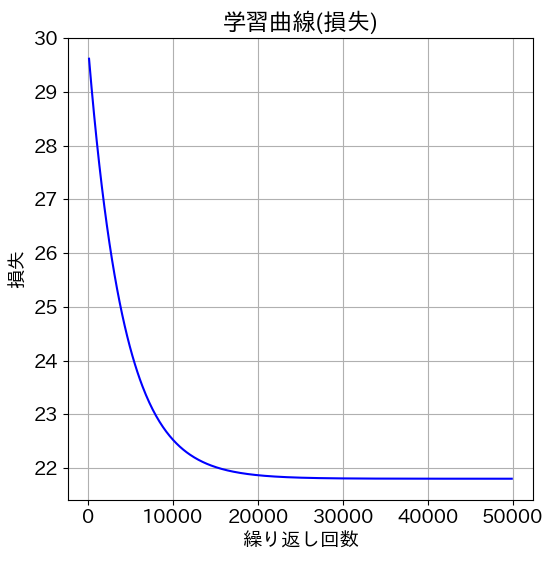

In [46]:
# 学習曲線の表示（損失）
# 最初の１つを除く
plt.plot(history[1:, 0], history[1:, 1], 'b')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.show()

回帰直線を表示

In [47]:
# 回帰直線の算出

# xの最小値、最大値
xse = np.array((x.min(), x.max())).reshape(-1,1)
Xse = torch.tensor(xse).float()

with torch.no_grad():
  Yse = net(Xse)

print(Yse.numpy())

[[-2.2189]
 [45.2121]]


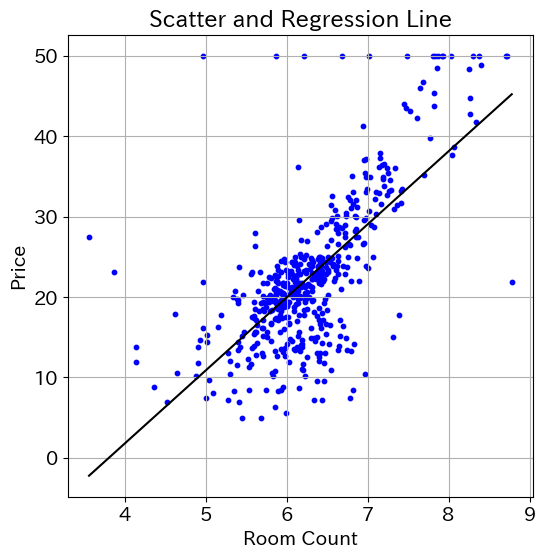

In [49]:
# 散布図と回帰直線の描画
plt.scatter(x, yt, s=10, c='b')
plt.xlabel('Room Count')
plt.ylabel('Price')
plt.plot(Xse.data, Yse.data, c='k')
plt.title('Scatter and Regression Line')
plt.show()

## 5.10 重回帰モデルへの拡張
- 前節までで作ったモデルは、単回帰
    - 入力変数は平均部屋数(RM)のみ
- 入力項目にLSTAT を追加（2入力）

In [51]:
# 列(LSTAT: 低所得者率)の追加
x_add = x_org[:, feature_names == 'LSTAT']
x2 = np.hstack((x, x_add))

# shapeの表示
print(x2.shape)

# 入力データxの表示
print(x2[:5, :])

(506, 2)
[[6.575 4.98 ]
 [6.421 9.14 ]
 [7.185 4.03 ]
 [6.998 2.94 ]
 [7.147 5.33 ]]


In [52]:
# 今度は入力次元数=2になった
n_input = x2.shape[1]
print(n_input)

# モデルインスタンスの生成
net = Net(n_input, n_output)

2


In [53]:
# インスタンス変数netのパラメータがどう変わったか、いくつかの方法で確認
# predict.weightが2次元に変わったことが見て取れる
for parameter in net.named_parameters():
    print(f"変数名: {parameter[0]}")
    print(f"変数値: {parameter[1].data}")

変数名: l1.weight
変数値: tensor([[1., 1.]])
変数名: l1.bias
変数値: tensor([1.])


In [55]:
# モデルの概要表示
print(net) # in_features=2となっている

Net(
  (l1): Linear(in_features=2, out_features=1, bias=True)
)


In [56]:
# モデルのサマリー表示
from torchinfo import summary
summary(net, (2,))
# param # の欄に注目。パラメータ数が3(weight2個とbias1個)になっている

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1]                       --
├─Linear: 1-1                            [1]                       3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [57]:
# 入力変数x2のテンソル変数化
# labels, labels1は前のものをそのまま利用
inputs = torch.tensor(x2).float()

In [58]:
# 準備完了。初期設定と繰り返し処理は単回帰と同じ。

# 初期化処理

# 学習率
lr = 0.01

# インスタンス生成　(パラメータ値初期化)
net = Net(n_input, n_output)

# 損失関数： 平均2乗誤差
criterion = nn.MSELoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50000

# 評価結果記録用 (損失関数値のみ記録)
history = np.zeros((0,2))

In [59]:
# 繰り返し計算メインループ

for epoch in range(num_epochs):
    
    # 勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)
  
    # 誤差計算
    # 「ディープラーニングの数学」に合わせて2で割った値を損失とした
    loss = criterion(outputs, labels1) / 2.0

    # 勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    # 100回ごとに途中経過を記録する
    if ( epoch % 100 == 0):
        history = np.vstack((history, np.array([epoch, loss.item()])))
        print(f'Epoch {epoch} loss: {loss.item():.5f}')

Epoch 0 loss: 112.06398
Epoch 100 loss: 3753836771411204665009321803776.00000
Epoch 200 loss: inf
Epoch 300 loss: nan
Epoch 400 loss: nan
Epoch 500 loss: nan
Epoch 600 loss: nan
Epoch 700 loss: nan
Epoch 800 loss: nan
Epoch 900 loss: nan
Epoch 1000 loss: nan
Epoch 1100 loss: nan
Epoch 1200 loss: nan
Epoch 1300 loss: nan
Epoch 1400 loss: nan
Epoch 1500 loss: nan
Epoch 1600 loss: nan
Epoch 1700 loss: nan
Epoch 1800 loss: nan
Epoch 1900 loss: nan
Epoch 2000 loss: nan
Epoch 2100 loss: nan
Epoch 2200 loss: nan
Epoch 2300 loss: nan
Epoch 2400 loss: nan
Epoch 2500 loss: nan
Epoch 2600 loss: nan
Epoch 2700 loss: nan
Epoch 2800 loss: nan
Epoch 2900 loss: nan
Epoch 3000 loss: nan
Epoch 3100 loss: nan
Epoch 3200 loss: nan
Epoch 3300 loss: nan
Epoch 3400 loss: nan
Epoch 3500 loss: nan
Epoch 3600 loss: nan
Epoch 3700 loss: nan
Epoch 3800 loss: nan
Epoch 3900 loss: nan
Epoch 4000 loss: nan
Epoch 4100 loss: nan
Epoch 4200 loss: nan
Epoch 4300 loss: nan
Epoch 4400 loss: nan
Epoch 4500 loss: nan
Epoch 

- 学習失敗！
- 損失関数がinf → nanになってしまっている
- 理由は、学習率0.01が大きすぎたこと。

## 5.11 学習率の変更

In [60]:
# 繰り返し回数
#num_epochs = 50000
num_epochs = 2000

# 学習率
#lr = 0.01
lr = 0.001

# モデルインスタンスの生成
net = Net(n_input, n_output)

# 損失関数： 平均2乗誤差
criterion = nn.MSELoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

In [61]:
# 繰り返し計算メインループ

# 評価結果記録用 (損失関数値のみ記録)
history = np.zeros((0,2))

for epoch in range(num_epochs):
    
    # 勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)
  
    # 誤差計算
    loss = criterion(outputs, labels1) / 2.0

    #勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    # 100回ごとに途中経過を記録する
    if ( epoch % 100 == 0):
        history = np.vstack((history, np.array([epoch, loss.item()])))
        print(f'Epoch {epoch} loss: {loss.item():.5f}')

Epoch 0 loss: 112.06398
Epoch 100 loss: 25.35892
Epoch 200 loss: 16.39106
Epoch 300 loss: 15.40302
Epoch 400 loss: 15.29414
Epoch 500 loss: 15.28211
Epoch 600 loss: 15.28076
Epoch 700 loss: 15.28059
Epoch 800 loss: 15.28054
Epoch 900 loss: 15.28051
Epoch 1000 loss: 15.28048
Epoch 1100 loss: 15.28046
Epoch 1200 loss: 15.28043
Epoch 1300 loss: 15.28040
Epoch 1400 loss: 15.28037
Epoch 1500 loss: 15.28034
Epoch 1600 loss: 15.28031
Epoch 1700 loss: 15.28028
Epoch 1800 loss: 15.28026
Epoch 1900 loss: 15.28023


In [62]:
# 損失初期値、最終値

print(f'損失初期値: {history[0,1]:.5f}')
print(f'損失最終値: {history[-1,1]:.5f}')

損失初期値: 112.06398
損失最終値: 15.28023


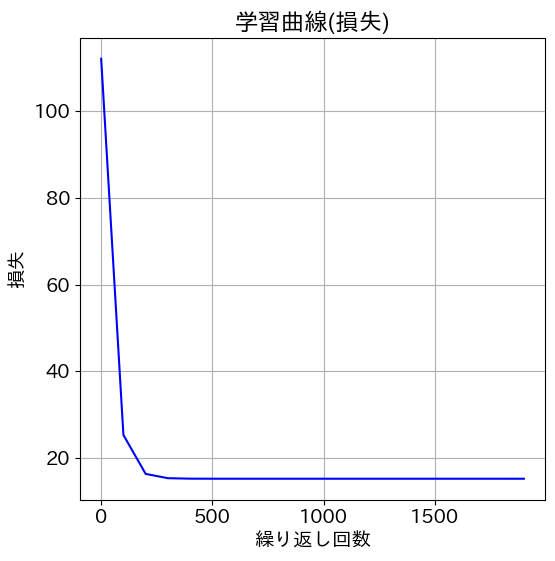

In [63]:
# 学習曲線の表示 (損失)

plt.plot(history[:,0], history[:,1], 'b')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.show()